In [137]:
%load_ext autoreload
%autoreload 2

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import umap

from sklearn import manifold, decomposition, preprocessing, neighbors

from state_of_the_artefact.systems import Recommender, Agent
from state_of_the_artefact.utilities import one_hot, reverse_sequences

sns.set()

### SIMULATION DATA AND PARAMETERS

In [139]:
fname_simulation = "sim_a8_e25_uniform_origin_2020-08-08T12-24-29.gzip"
data = pd.read_pickle(os.path.join("..", "data", "output", fname_simulation))

P = data["parameters"]
T = data["timings"]

print(pd.concat([P, T]).to_string())

n_epochs                               25
n_agents                                8
n_neighbours                            1
n_artefacts                            10
sample_mode                        origin
novelty_preference                   0.25
budget                                100
interaction_mode                  uniform
save_remote                         False
duration                          968.269
start_time            2020-08-08T12-24-29
end_time              2020-08-08T12-40-37


### SETUP VARIABLES

In [140]:
a_labels = [f"agent_{i}" for i in range(data["parameters"].n_agents)]

e = 1  # * 25 epochs
domain = pd.DataFrame([v[e] for k, v in data["domain"][e:e + 1].items()])
artefacts = np.array([np.array(a) for a in domain["domain_z_mean"]])

## Evaluation

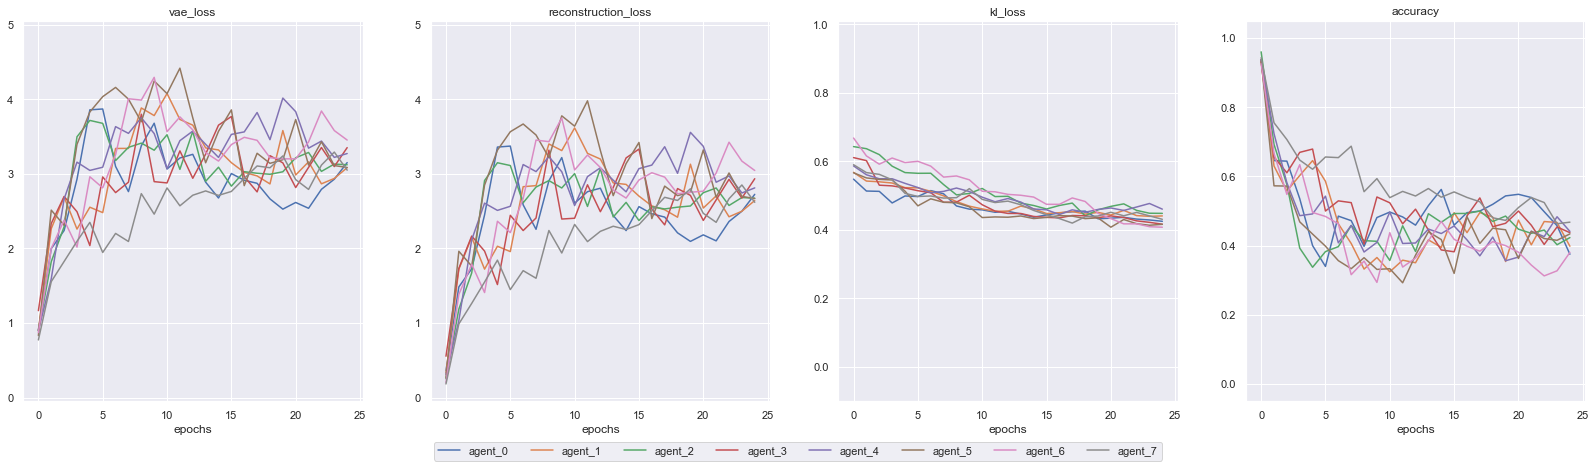

In [141]:
fig, ax = plt.subplots(1, 4, figsize=(28, 6))
keys = ["vae_loss", "reconstruction_loss", "kl_loss", "accuracy"]
ylims = [(-.05, 5.05), (-.05, 5.05), (-0.02, 1.02), (-.02, 1.02)]

for i, key in enumerate(keys):
    for j in range(P.n_agents):
        data["evaluations"][key][j::P.n_agents].plot(label=a_labels[j], ax=ax[i], use_index=False, ylim=ylims[i])
        ax[i].set_title(key)
        ax[i].set_xlabel("epochs")

fig.legend(loc="lower center", labels=a_labels, ncol=8)
plt.show()

## Initial Agent Positions

NOTE: Using a random sample for illustrative purposes.

In [ ]:
domain_seed_path = os.path.join("..", "data", "seeds", "domain_seed.npy")
agent_seeds_path = os.path.join("..", "data", "seeds", "agent_seeds.npy")
model_path = os.path.join("..", "data", "models")

try:
    domain_seed = np.load(domain_seed_path, allow_pickle=True)
    agent_seeds = np.load(agent_seeds_path, allow_pickle=True)
except IOError as e:
    print(e.args)

recommender = Recommender(domain_seed, model_path=model_path)
agents = [Agent(i, seed, model_path=model_path) for i, seed in enumerate(agent_seeds)]

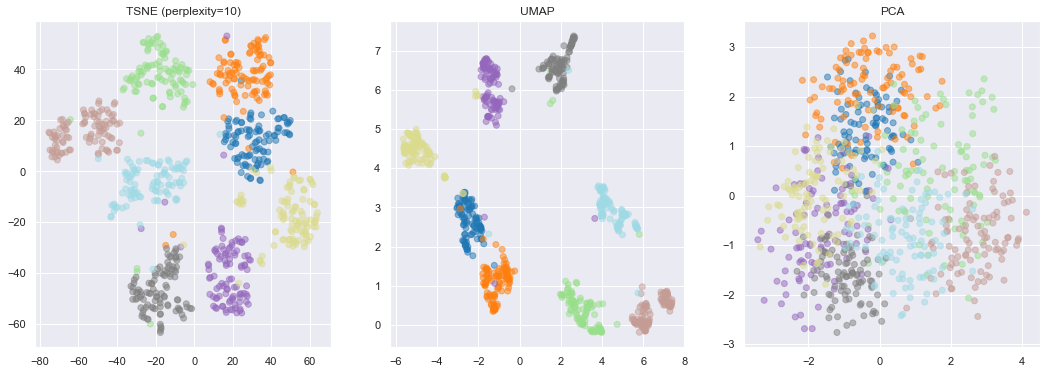

In [156]:
samples = []
labels = []

for i, agent in enumerate(agents):
    z = tf.random.normal((100, 32), 0.0, 0.25)
    samples += list(agent.decode(z, apply_onehot=True))
    labels += list(np.ones(100, dtype="int") * i)

assert np.array(samples).shape == (800, 16, 12), f"{np.array(samples).shape}"
assert np.array(labels).shape == (800,), f"{np.array(labels).shape}"

samples_reverse = reverse_sequences(np.array(samples))
z_means, _, _ = recommender.encode(samples_reverse)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
perplexities = [10]

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        tsne = manifold.TSNE(n_components=2, perplexity=perplexities[i - 1], random_state=42)
        embedded = tsne.fit_transform(z_means)
        ax.set_title(f"TSNE (perplexity={perplexities[i]})")
    elif i == 1:
        reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.0, metric="euclidean")
        embedded = reducer.fit_transform(z_means)
        ax.set_title("UMAP")
    else:
        pca = decomposition.PCA(n_components=2)
        embedded = pca.fit_transform(z_means)
        ax.set_title("PCA")

    ax.scatter(embedded[:, 0], embedded[:, 1], c=labels, cmap="tab20", alpha=.5)

plt.show()

## FIELD

TSNE/UMAP plot of the agents artefacts at the end of the simulation

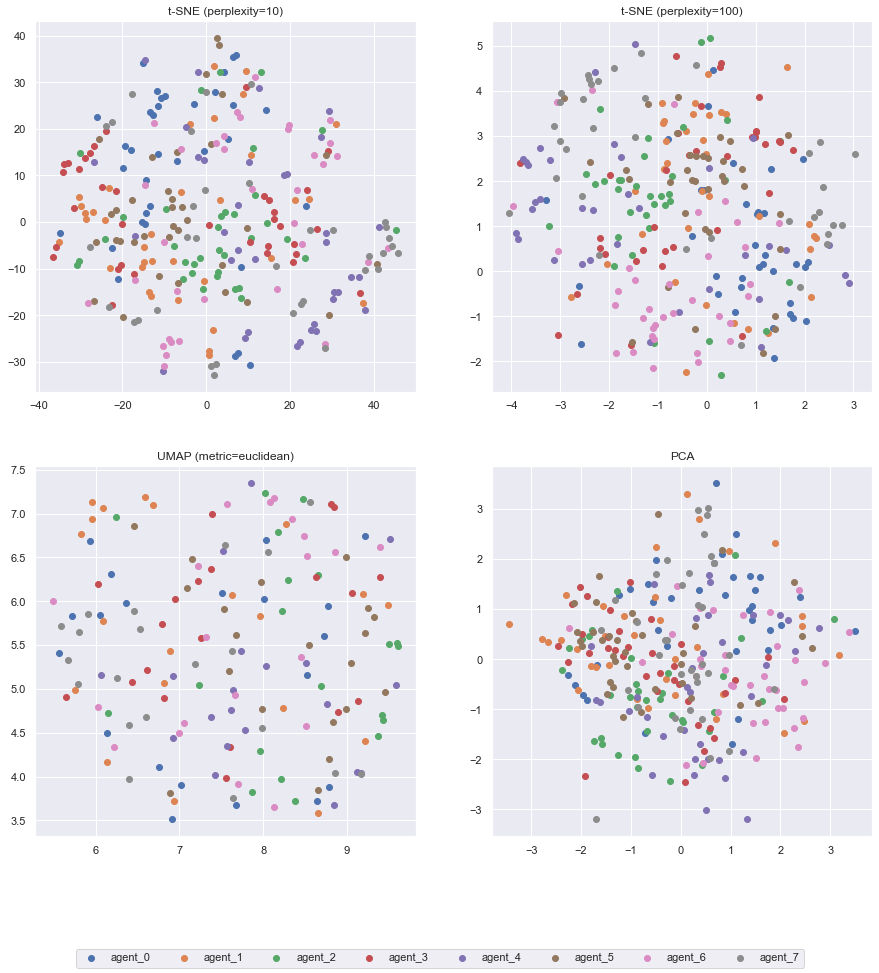

Number of artefacts: 280


In [118]:
# TODO: Make series of the same metric for every n epochs.

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
perplexities = [10, 100]

for i, ax in enumerate(axs.flatten()):
    if i < 2:
        tsne = manifold.TSNE(n_components=2, random_state=42, perplexity=perplexities[i])
        embedded = tsne.fit_transform(artefacts)
        ax.set_title(f"t-SNE (perplexity={perplexities[i]})")
    elif i == 2:
        reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.0, metric="euclidean")
        embedded = reducer.fit_transform(umap_artefacts)
        ax.set_title(f"UMAP (metric={metric})")
    else:
        pca = decomposition.PCA(n_components=2)
        embedded = pca.fit_transform(artefacts)
        ax.set_title("PCA")

    for j, label in enumerate(a_labels):
        x, y = embedded[j::P.n_agents, 0], embedded[j::P.n_agents, 1]
        ax.scatter(x, y, label=label)
    
fig.legend(labels=a_labels, loc="lower center", ncol=P.n_agents)
plt.show()
print(f"Number of artefacts: {len(artefacts)}")

## INDIVIDUAL

Novelty Preferences -> Density/Volume

Sampling Modes